@author: Méndez Pool Joan de Jesús

# Gallery Art Vigilance

We assume exists a gallery art, we should vigilance different artworks distributive inside a building that is asume like a simple polygon.

The gallery is looking for to set cameras(fixed and with a posibilty to rotary) for cheack the artworks, the conditions are:

- The cameras allow view each space of the gallery(it is not should be any blind point).
- The quantity of the cameras should be the posibble minimun.

## Implementation 

**Objective**: To color the vertices of a general polygon.

**Instructions:**

To develop this project, they must consider that the polygon is defined as follows:

1. The coordinates of the vertices are registered in a DataFrame with columns *x* and *y*.
2. The polygon contains an arbitrary number of vertices and is constructed by joining successive vertices of the DataFrame with lines.
3. The polygon must be read by means of a function called $\texttt{GeneratePolygon}$, which does not receive parameters, but returns the DataFrame [as used in this book].

For an **arbitrary polygon** constructed with the function $\texttt{GeneratePolygon}$, its implementation must do the following:

1. Triangulate the vertices of the polygon using Delaunay's algorithm (Using Shapely it is a plus).
2. Construct a function that identifies whether a triangle, defined by its three vertices, is outside the original polygon.
3. Remove triangles located outside the original polygon from the Delaunay triangulation.
4. Apply the vertex coloring strategy defined in the previous section, using three different colors [you can select them arbitrarily]
5. Show, in a graph:
    5. The original polygon
    5. The colored vertices.
    5. The internal triangles obtained from the Delaunay algorithm.

## Coloring of the vertices of the triangulations

In [1]:
from Triangulacion import GeneratePolygon
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
# Shapely
from shapely import geometry
from shapely.ops import triangulate
import time
%matplotlib inline

In [2]:
class Polygon_Coloring:
    def __init__(self, data, shply=False ):
        self.df = data.copy(deep=True)
        self.shply = shply
        if(self.shply):
            self.triangulation, self.gravitycenter = self.Determine_Shapely_Triangulation(df)
        else:
            self.triangulation, self.gravitycenter = self.Determine_Delaunay_Triangulation(df)
        self.adjmatrix = self.AdjacencyMatrix()
        self.Solve()
        
    def PlotPolygon(self, title, cent=False ,trian=False, colr=False):
        # Plot Polygon Solution
        plt.title(title)
        plt.axis("off")
        if(cent):
            # gravitycenter
            plt.scatter(self.gravitycenter[:,0], self.gravitycenter[:,1], marker='.', c='y' )
        if (trian):
            # Triangulation
            for t in self.triangulation:
                # Polygon Triangulation Points 
                if(self.shply):
                    plt.plot( t[:,0], t[:,1], "r:")
                else:
                    plt.plot([ self.df["x"][t[i]] for i in range(3) ], 
                             [ self.df["y"][t[i]] for i in range(3) ], "r:")
        # Lines
        plt.plot(self.df["x"], self.df["y"], c='k')
        if (colr):
            # Color vertices
            plt.scatter(self.df["x"], self.df["y"], c=self.df["c"])
        plt.show()
    
    # Scipy and Matplotlib
    def Determine_Delaunay_Triangulation(self, df):
        # Create a polygon
        #polygon = mplPath.Path(np.array([ [row["x"], row["y"]] for index, row in df.iterrows() ]))
        polygon = mplPath.Path(df)
        # Delaunay triangulation algorithm
        delatri = Delaunay(df.values) 
        # Calculate gravity center of each triangulation
        centers = [ [df["x"][tri].mean(), df["y"][tri].mean()] for tri in delatri.simplices ]
        # Get index for all triangulation inside the polygon
        index = polygon.contains_points(centers)
        # Get all triangulation inside the polygon
        triangulation = np.array(delatri.simplices)[index]
        # Get gravity center of all triangulation inside the polygon
        gravitycenter = np.array(centers)[index]
        return (triangulation, gravitycenter)
    
    # Shapely
    def Determine_Shapely_Triangulation(self, df):
        # Create a polygon
        points = geometry.MultiPoint(df.values)
        line = geometry.LineString(points)
        polygon = geometry.Polygon(line)
        # Triangulation
        triangles = triangulate(points)
        # Get all points for each triangulation
        triangulation = np.array([ [ point for point in triangle.exterior.coords[:-1] ] 
                                  for triangle in triangles ])
        # Calculate gravity center for each triangulation
        gravitycenter = np.array([ [tri[:,0].mean(), tri[:,1].mean()]  for tri in triangulation ])
        # Get all triangulation index inside the polygon
        index = np.array([ polygon.contains(geometry.Point(tri[:,0].mean(), tri[:,1].mean()))  
                          for tri in triangulation ])
        return (triangulation[index], gravitycenter[index])
    
    def AdjacencyMatrix(self):
        n = len(self.triangulation)
        # Create a 'n x n' zeros matrix
        adj = np.zeros((n, n), dtype=int)
        # Verify all adjacencies of the graph
        for i, currenttrian in enumerate(self.triangulation):
            j = i + 1
            if(self.shply):
                S = set([ tuple(tri) for tri in currenttrian ])
            # Determines whether the current triangle is adjacent to all subsequent ones in the list
            for nexttrian in self.triangulation[i+1:]:
                vertices = 0
                # Verify if at least the triangles to evaluate have at least two vertices in common
                if(self.shply):          
                    for point in nexttrian:
                        if tuple(point) in S:
                            vertices += 1
                else:
                    for index in currenttrian:
                        if index in nexttrian:
                            vertices += 1
                # If the condition is true then the adjacency is saved with the value 1 
                # in the current positions
                if vertices == 2:
                    adj[i][j]=1
                    adj[j][i]=1
                j+=1
        return adj
    
    def AdjacencyList(self, ls):
        # Create a set that contains as information the adjacency list given a node of the graph
        adjls = set( [ i for i, l in enumerate(ls) if l==1 ] )
        return adjls
    
    # Given the simplification of the algorithm and the usefulness of the graph, the first time 
    # this routine is executed, the three vertices are saved, but from the next interaction, 
    # due to adjacency, only the color is added to the missing vertex
    def DefineVerticesColours(self, trian, vertices):
        # Create a set with the list of available colors [ Modifiable ]
        colours = set(['r', 'g', 'b'])
        # Empty set that represents vertices that have already been painted previously (Painted Vertices)
        painted = set()  
        # Determine each point of the triangle to check if it has already been painted before
        lsvertices = []
        for vertex in trian:
            # Performs the query in 'vertices', in vertices because it contains 
            # the coloring information of the vertices
            if(self.shply):
                q = "(x=={}) & (y=={})".format(vertex[0], vertex[1])
            else:
                q = 'i==' + str(vertex)
            # Query dataframe
            qry = vertices.query(q)
            qry.reset_index(drop=True, inplace=True)
            if qry.empty:
                # If the vertex was not found in the dataframe, 
                # it is saved in the list of vertices to be painted
                lsvertices.append(vertex)
            else:
                # If the vertices were found then the color is saved in the set of painted
                painted.add(qry.loc[0]['c'])
        # Calculate the list of the difference of the set of colours 
        # with respect to the vertices already painted
        # With this operation we always obtain the remaining color
        lscolours = list(colours.difference(painted))
        # lscolours = list(colours - painted)  # Equivalent to the instruction of the previous line
        # Now the vertices to be painted are added to the dataframe with their respective color
        for index, vertex in enumerate(lsvertices):
            if(self.shply):
                q = "(x=={}) & (y=={})".format(vertex[0], vertex[1])
                # Query dataframe
                qry = self.df.query(q)
                d = {'i':qry.index[0] ,'x':vertex[0], 'y':vertex[1], 'c':str(lscolours[index])}
            else:
                d = {'i':vertex, 'c':str(lscolours[index])}
            vertices = vertices.append(d, ignore_index=True, sort=False)
        return vertices

    # 'Deep First Search' 
    def DFS(self, graph, start):
        if(self.shply):
            vertices = pd.DataFrame(columns=['i', 'x', 'y', 'c'])

        else:
            vertices = pd.DataFrame(columns=['i', 'c'])
        stack = [ start ]
        visited = set()
        while stack:
            vertex = stack.pop()
            if not vertex in visited:
                visited.add(vertex)
                stack.extend((self.AdjacencyList(graph[vertex])).difference(visited))
                # Equivalent to the instruction of the previous line
                #stack.extend(self.AdjacencyList(graph[vertex]) - visited) 
                # Modification in the DFS to obtain a dataframe that contains the coloration of the vertices
                vertices = self.DefineVerticesColours(self.triangulation[vertex], vertices)
        vertices = vertices.sort_values(by=["i"], ascending=True)
        vertices.reset_index(drop=True, inplace=True)
        # The init point is the final point
        if(self.shply):
            d = {'i': vertices.shape[0], 'x': vertices["x"][-1:], 
                 'y':vertices['y'][-1:], 'c':vertices.loc[0]['c']}
        else:
            d = {'i': vertices.shape[0], 'c':vertices.loc[0]['c']}
        vertices = vertices.append(d, ignore_index=True, sort=False)
        return vertices
    
    def Solve(self):
        # Interaction of the Graph and assignment of colors to vertices
        colored = self.DFS(self.adjmatrix, 0)
        # Assigning colors to the dataframe of vertices
        self.df['c'] = colored['c']

We visualize the vertices of the polygon in the DataFrame.

In [3]:
df = GeneratePolygon()
df

,x,y
0,0,0
1,0,-5
2,3,-7
3,0,-9
4,5,-9
5,7,-7
6,7,-9
7,12,-9
8,12,-6
9,14,-6


### Scipy and Matplotlib

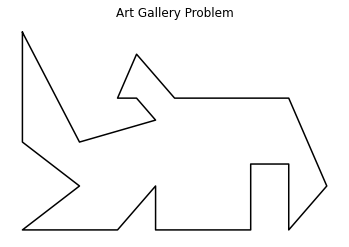

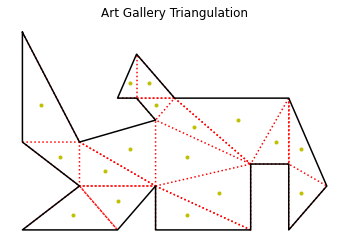

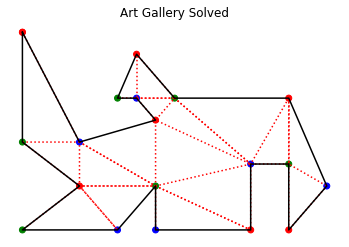

--- 3.79 seconds ---


In [4]:
start_time = time.time()

A1 = Polygon_Coloring(df)
A1.PlotPolygon("Art Gallery Problem")
A1.PlotPolygon("Art Gallery Triangulation", cent=True, trian=True)
A1.PlotPolygon("Art Gallery Solved", trian=True, colr=True)

print("--- {:.2f} seconds ---".format(time.time() - start_time))

### Shapely

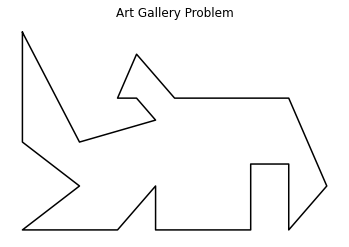

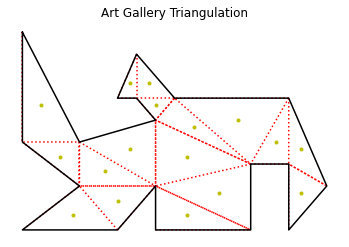

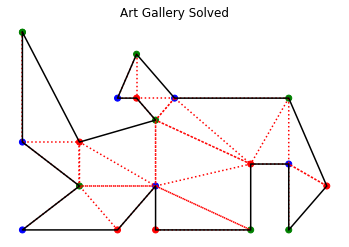

--- 3.56 seconds ---


In [5]:
start_time = time.time()

A2 = Polygon_Coloring(df, shply=True)
A2.PlotPolygon("Art Gallery Problem")
A2.PlotPolygon("Art Gallery Triangulation", cent=True, trian=True)
A2.PlotPolygon("Art Gallery Solved", trian=True, colr=True)

print("--- {:.2f} seconds ---".format(time.time() - start_time))

## Summary

By handling the correct data structures, the problem can be solved in a simple way without having to resort to crude algorithms and inefficient, in the same way we see the importance of the geometric figure known as a triangle, it is a figure of vital importance in Geometry already that triangles can be created from Polygons, being a key piece in the solution of the problem the Delaunay Triangulation Algorithm. It was possible to achieve the implementation of the coloring of vertices thanks to the appropriate algorithms including the DFS for the composition of a solution that can solve this problem in as many Polygons as possible.


## References

- The scenario of the problematic was provided by Dr Fernando Gómez García for the subject <i>Computational Geometry</i>. Special thanks to Dr.Special thanks to Dr.